In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import copy

In [2]:
linear_trend = np.linspace(0, 10, 5)

In [3]:
x = np.linspace(0, 10 * np.pi, 10)
increasing_sine_wave = np.sin(x) + 0.1 * x  # Increasing sine wave

In [4]:
exponential_trend = np.exp(np.linspace(0, 2, 13))

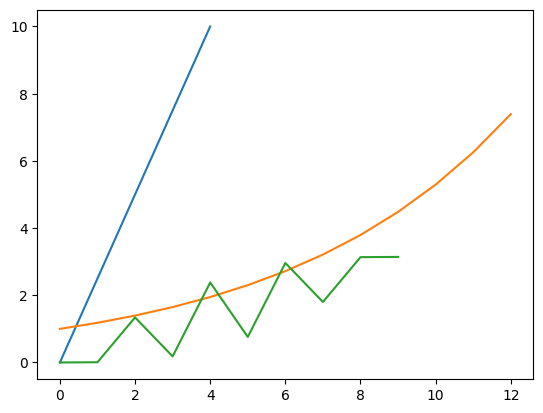

In [5]:
plt.plot(linear_trend)
plt.plot(exponential_trend)
plt.plot(increasing_sine_wave)
# plt.legend(['linear', ''])
plt.show()

In [6]:
print(linear_trend)
print(exponential_trend)
print(increasing_sine_wave)

[ 0.   2.5  5.   7.5 10. ]
[1.         1.18136041 1.39561243 1.64872127 1.94773404 2.30097589
 2.71828183 3.21127054 3.79366789 4.48168907 5.29449005 6.25470095
 7.3890561 ]
[0.         0.00704571 1.34091931 0.18117215 2.38107115 0.7605215
 2.96042051 1.80067334 3.13454695 3.14159265]


# trend data

In [7]:
np.random.seed(42)  # for reproducibility
n_samples = 10000
ages = np.concatenate([
    np.random.normal(60, 10, int(0.8 * n_samples)),  # 70% of the data around age 60
    np.random.normal(30, 10, int(0.2 * n_samples))   # 30% of the data around age 30
])
ages = np.clip(ages, 0, 100)  

In [8]:
def generate_trends(num_sequences, max_length, beta, noise):
    np.random.seed(42)  # for reproducibility
    data = {}

    for patid in tqdm(range(num_sequences)):
        length = np.random.randint(5, max_length)
        trend_type = np.random.choice(['increasing', 'decreasing'])
        x = np.linspace(0, 1, length)
        
        if trend_type == 'increasing':
            y = np.polyval(np.polyfit(x, np.random.rand(length) + np.linspace(0, 2, length), 2), x) +ages[patid]*beta
        else:
            y = np.polyval(np.polyfit(x, np.random.rand(length) + np.linspace(2, 0, length), 2), x) +ages[patid]*beta

        # Adding some noise
        y += np.random.normal(scale=noise, size=length)
        
        # Ensuring no exact linear trends
        y = y + np.sin(2 * np.pi * np.random.rand() * x)
        
        data[patid] = {}
        data[patid]['seq'] = y
        data[patid]['age'] = ages[patid]
        if trend_type == 'increasing':
            data[patid]['label'] = 1
        else:
            data[patid]['label'] = 0

    return data

# Generate 10 sequences with a maximum length of 50
trends_data = generate_trends(10000, 50, 0.1, 0.6)


100%|██████████| 10000/10000 [00:01<00:00, 6266.44it/s]


In [9]:
la = []
for k,v in trends_data.items():
    la.append(v['label'])

In [10]:
sum(la)

5079

6.542945507351557


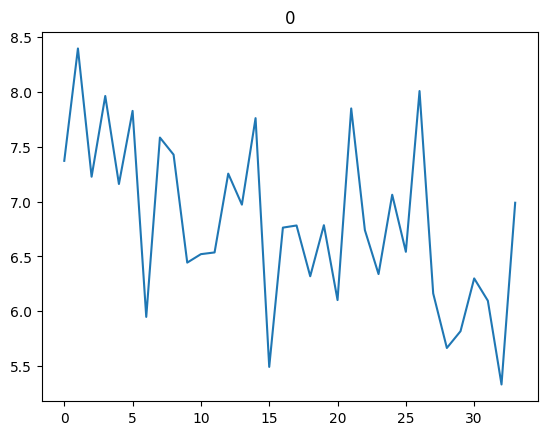

In [11]:
i = 2546
plt.plot(trends_data[i]['seq'])
plt.title(trends_data[i]['label'])
print(trends_data[i]['seq'][25])

In [12]:
import pickle
with open('datasets/noise0.6_beta0.1.pickle','wb') as handle:
    pickle.dump(trends_data, handle)

# Trend data with missingness

### missing completely at random (MCAR)

In [13]:
import copy

In [14]:
def introduce_mcar(data, missing_rate=0.3):
    np.random.seed(111)
    for patid, values in data.items():
        seq = values['seq']
        mask = np.random.rand(len(seq)) > missing_rate # if random number is greater than missing_rate, the value will be kept. As the random number is from 0 to 1 there are 1-missing_rate percent chance that the value will be kept
        seq[~mask] = np.nan  # Introducing missing values
        data[patid]['seq'] = seq
    return data

In [15]:
import pickle
with open('datasets/noise0.6_beta0.1.pickle','rb') as handle:
    trends_data = pickle.load(handle)

In [16]:
data_miss = introduce_mcar(copy.deepcopy(trends_data))

Text(0.5, 1.0, '0')

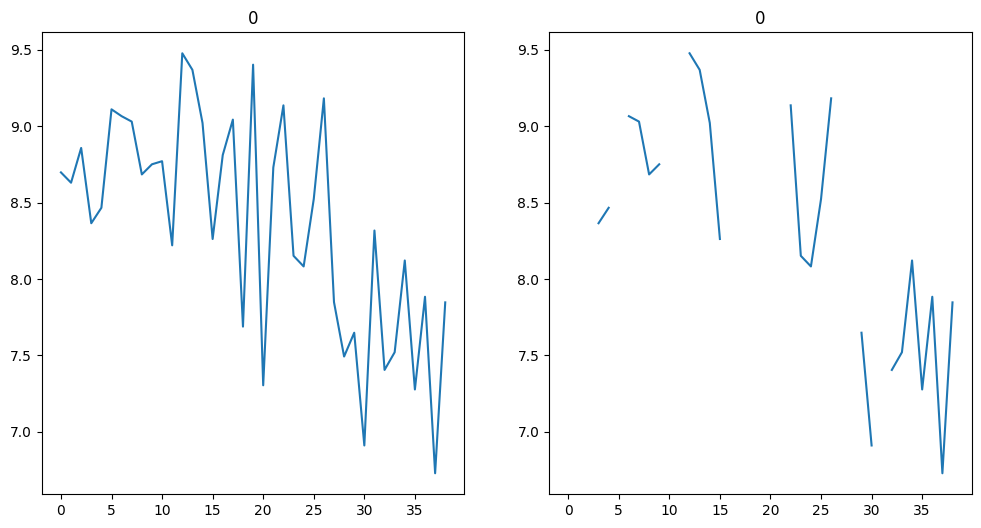

In [17]:
# miss = 0.1
i = 70
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(trends_data[i]['seq'])
axes[0].set_title(trends_data[i]['label'])

axes[1].plot(data_miss[i]['seq'])
axes[1].set_title(data_miss[i]['label'])

In [18]:
data_miss[0]

{'seq': array([9.56717963,        nan, 9.16822658, 7.85247289,        nan,
               nan,        nan, 9.07508737,        nan, 8.76370568,
        8.04298938,        nan,        nan, 9.51919765, 9.07494484,
               nan, 9.02878058,        nan,        nan, 9.14315123,
        9.37332568, 9.29095372, 8.20493469, 8.49798201, 8.8560254 ,
        9.21501931, 8.31323731,        nan, 7.87476784,        nan,
        8.9580173 , 9.24794569, 8.35316391,        nan, 8.53306131,
               nan, 8.44645261, 9.10690611, 8.11554341, 9.02728596,
        6.46664398, 8.4801838 , 7.98641582]),
 'age': np.float64(64.96714153011233),
 'label': 0}

In [19]:
for key, pat_dat in data_miss.items():
    time_stamp = np.where(~np.isnan(pat_dat['seq']))[0]
    pat_dat['timestamps'] = time_stamp

In [20]:
with open('datasets/mcar_beta0.1.pickle','wb') as handle:
    pickle.dump(data_miss, handle)

In [21]:
max_len = 0
for i, d in data_miss.items():
    if max_len<len(d['seq']):
        max_len = len(d['seq'])

In [22]:
max_len

49

### Missing at random (MAR)

In [23]:
def introduce_mar(data, missing_rate = 0.3, age_threshold = 50):
    np.random.seed(111)
    for patid, values in data.items():
        seq = values['seq']
        age = values.get('age')
        
        # calculate missing rate (assume to be 0.15 higher above age threshold)
        adjusted_missing_rate = missing_rate if age < age_threshold else min(1, missing_rate + 0.15)
        
        # create mask to introduce missing values
        mask = np.random.rand(len(seq)) > adjusted_missing_rate
        seq[~mask] = np.nan
        
        data[patid]['seq'] = seq
    return data

Text(0.5, 1.0, '0')

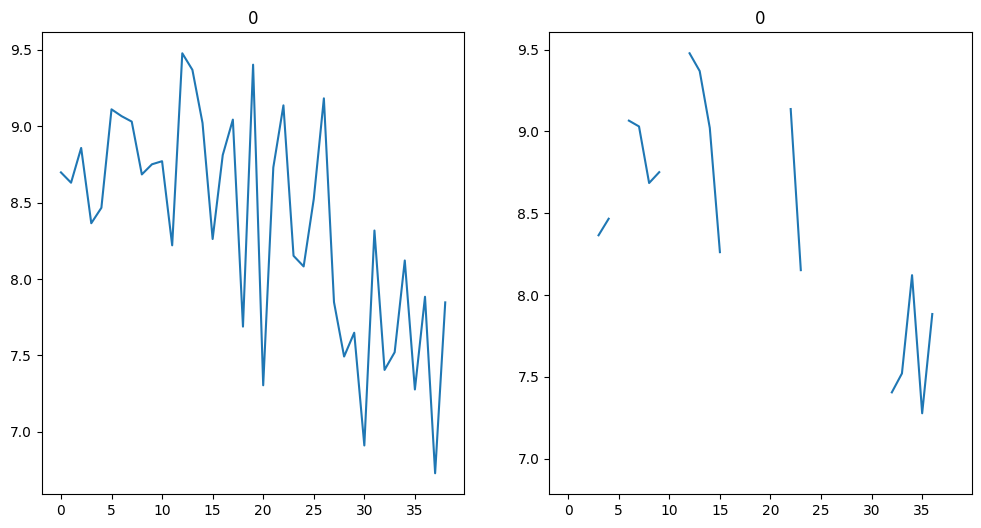

In [24]:
import pickle
with open('datasets/noise0.6_beta0.1.pickle','rb') as handle:
    trends_data = pickle.load(handle)
    
data_miss = introduce_mar(copy.deepcopy(trends_data))

# miss = 0.1
i = 70
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(trends_data[i]['seq'])
axes[0].set_title(trends_data[i]['label'])

axes[1].plot(data_miss[i]['seq'])
axes[1].set_title(data_miss[i]['label'])

In [25]:
for key, pat_dat in data_miss.items():
    time_stamp = np.where(~np.isnan(pat_dat['seq']))[0]
    pat_dat['timestamps'] = time_stamp

In [26]:
with open('datasets/mar_beta0.1.pickle','wb') as handle:
    pickle.dump(data_miss, handle)

In [27]:
max_len = 0
for i, d in data_miss.items():
    if max_len<len(d['seq']):
        max_len = len(d['seq'])
max_len

49

### Missing not at random (MNAR)

In [28]:
def introduce_mnar(data, base_rate = 0.3, value_threshold = 8.0, value_factor = 0.10):
    # mnar includes missingness that is dependent on unobserved variables
    np.random.seed(111)
    for patid, values in data.items():
        seq = values['seq']
        # if the sequence value is more than the value threshold, increase the missingness
        missing_rates = np.clip(base_rate + value_factor * np.maximum(seq - value_threshold, 0))
        
        mask = np.random.rand(len(seq)) > missing_rates
        seq[~mask] = np.nan
        
        data[patid]['seq'] = seq
    return data

Text(0.5, 1.0, '0')

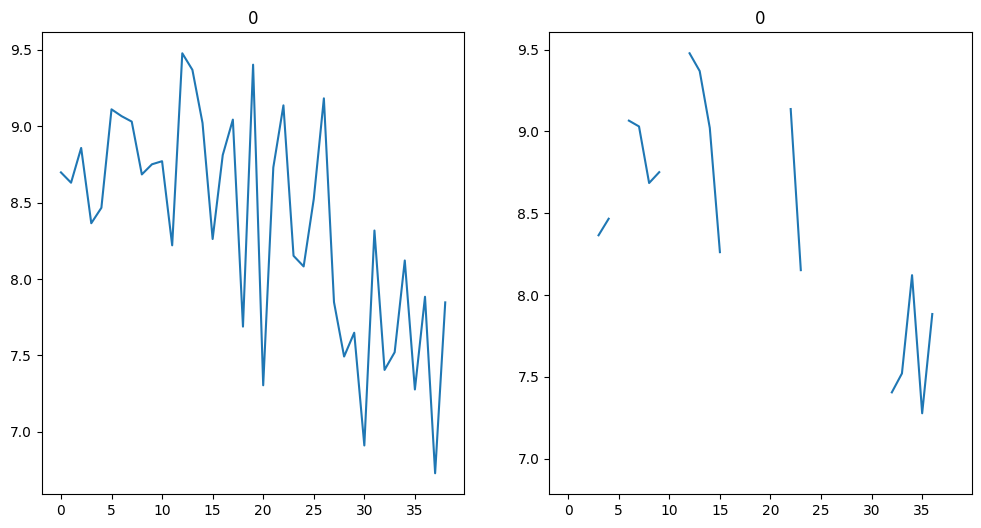

In [29]:
import pickle
with open('datasets/noise0.6_beta0.1.pickle','rb') as handle:
    trends_data = pickle.load(handle)
    
data_miss = introduce_mar(copy.deepcopy(trends_data))

# miss = 0.1
i = 70
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(trends_data[i]['seq'])
axes[0].set_title(trends_data[i]['label'])

axes[1].plot(data_miss[i]['seq'])
axes[1].set_title(data_miss[i]['label'])

In [30]:
for key, pat_dat in data_miss.items():
    time_stamp = np.where(~np.isnan(pat_dat['seq']))[0]
    pat_dat['timestamps'] = time_stamp

In [31]:
with open('datasets/mnar_beta0.1.pickle','wb') as handle:
    pickle.dump(data_miss, handle)

In [32]:
max_len = 0
for i, d in data_miss.items():
    if max_len<len(d['seq']):
        max_len = len(d['seq'])
max_len

49

# model training/evaluation

In [33]:
name = 'noise0.6_beta0.1'
model_name = 'mlp_fix'
add_annot = '_lr0.01'

In [34]:
import pickle
with open('datasets/'+name+'.pickle','rb') as handle:
    trends_data = pickle.load(handle)

In [35]:
from training import Training
import torch
# torch.cuda.set_device(0)
device = torch.device('cpu')
# training = Training(trends_data, model = model_name, device = device)
# training = Training(trends_data, model = model_name, hidden_dim = 1536, device = device)
# training = Training(trends_data, model = model_name, input_dim = 1536, hidden_dim=128, device = device)
training = Training(trends_data, model = model_name, input_dim = 49, hidden_dim=1536, device = device)

normalize data
create datasets
create trainloaders


normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.6876837102572123
Epoch [1/2000], Val Loss: 0.6829587321281433
Epoch [2/2000], Train Loss: 0.6785449951489766
Epoch [2/2000], Val Loss: 0.6819147644042969
Epoch [3/2000], Train Loss: 0.6704854919115703
Epoch [3/2000], Val Loss: 0.6751798334121704
Epoch [4/2000], Train Loss: 0.660768494606018
Epoch [4/2000], Val Loss: 0.6715194363594055
Epoch [5/2000], Train Loss: 0.6505887134869893
Epoch [5/2000], Val Loss: 0.665635139465332
Epoch [6/2000], Train Loss: 0.6366170865694681
Epoch [6/2000], Val Loss: 0.6618471298217773
Epoch [7/2000], Train Loss: 0.6216497604052226
Epoch [7/2000], Val Loss: 0.65985533285141
Epoch [8/2000], Train Loss: 0.6050439139207204
Epoch [8/2000], Val Loss: 0.6556198978424073
Epoch [9/2000], Train Loss: 0.5872419714132945
Epoch [9/2000], Val Loss: 0.6538047695159912
Epoch [10/2000], Train Loss: 0.5677705790996551
Epoch [10/2000], Val Loss: 0.6530617072582244
Epoch [11/2000], Train Loss: 0.

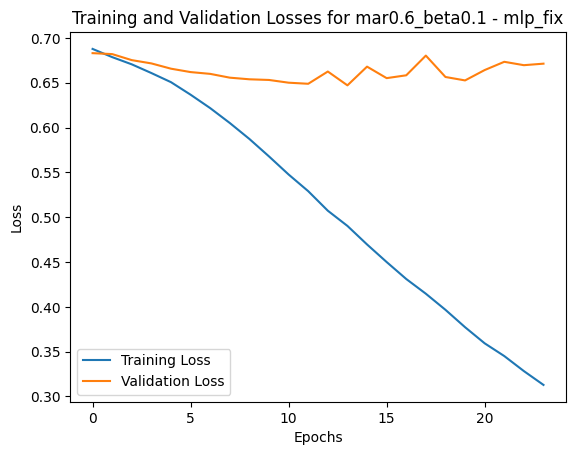

C:\Users\kr3164\AppData\Local\Temp\ipykernel_24292\776403985.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

Model loaded from outputs/baseline_mlp_fix_mar0.6_beta0.1_lr0.01.pt


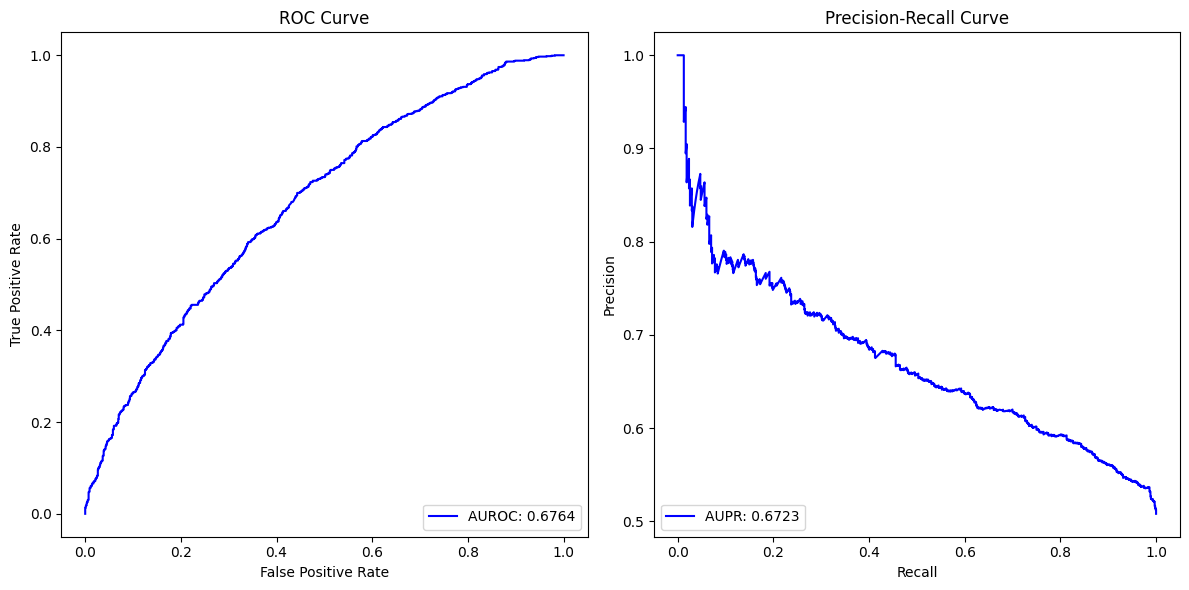

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.6858510773976644
Epoch [1/2000], Val Loss: 0.6751752939224244
Epoch [2/2000], Train Loss: 0.6669462281862895
Epoch [2/2000], Val Loss: 0.6694450216293335
Epoch [3/2000], Train Loss: 0.654433262348175
Epoch [3/2000], Val Loss: 0.6627831811904907
Epoch [4/2000], Train Loss: 0.64441330798467
Epoch [4/2000], Val Loss: 0.6592781720161438
Epoch [5/2000], Train Loss: 0.6337795658906301
Epoch [5/2000], Val Loss: 0.6593889470100402
Epoch [6/2000], Train Loss: 0.6233691035111745
Epoch [6/2000], Val Loss: 0.6521404178142548
Epoch [7/2000], Train Loss: 0.6076027002334595
Epoch [7/2000], Val Loss: 0.6458847267627716
Epoch [8/2000], Train Loss: 0.5894757913748423
Epoch [8/2000], Val Loss: 0.6359615914821625
Epoch [9/2000], Train Loss: 0.5676622785727183
Epoch [9/2000], Val Loss: 0.626193995475769
Epoch [10/2000], Train Loss: 0.5400081675847371
Epoch [10/2000], Val Loss: 0.6191683676242828
Epoch [11/2000], Train Loss: 0.

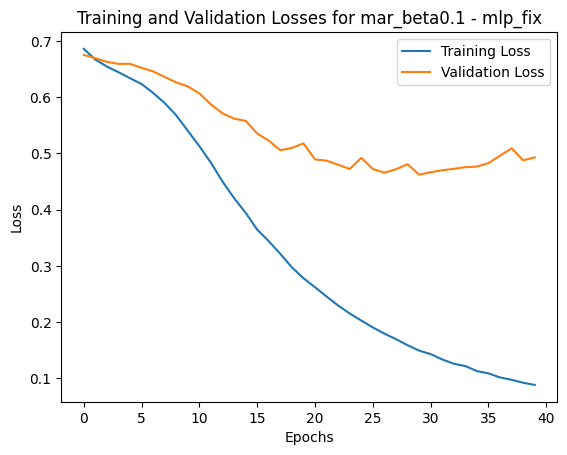

Model file not found: outputs/baseline_mlp_fix_mar_beta0.1_lr0.01.pt


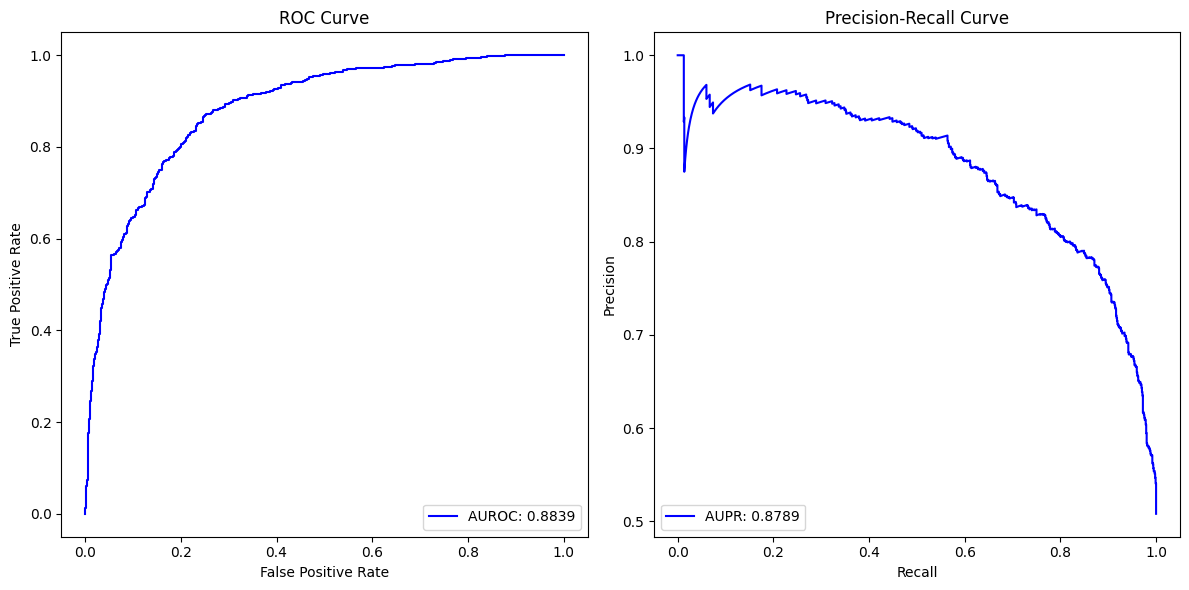

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.6819228582382202
Epoch [1/2000], Val Loss: 0.6674467430114747
Epoch [2/2000], Train Loss: 0.6557314796447754
Epoch [2/2000], Val Loss: 0.6558162040710449
Epoch [3/2000], Train Loss: 0.6399101088047028
Epoch [3/2000], Val Loss: 0.6467824511528015
Epoch [4/2000], Train Loss: 0.6282962760925292
Epoch [4/2000], Val Loss: 0.6413590905666351
Epoch [5/2000], Train Loss: 0.6150370930035909
Epoch [5/2000], Val Loss: 0.6355227322578431
Epoch [6/2000], Train Loss: 0.6043809982140859
Epoch [6/2000], Val Loss: 0.6312017202377319
Epoch [7/2000], Train Loss: 0.5876455186208089
Epoch [7/2000], Val Loss: 0.6208171617984771
Epoch [8/2000], Train Loss: 0.5674752598603566
Epoch [8/2000], Val Loss: 0.6099337730407715
Epoch [9/2000], Train Loss: 0.5434593981107076
Epoch [9/2000], Val Loss: 0.599255437374115
Epoch [10/2000], Train Loss: 0.517003449122111
Epoch [10/2000], Val Loss: 0.5807021157741546
Epoch [11/2000], Train Loss: 

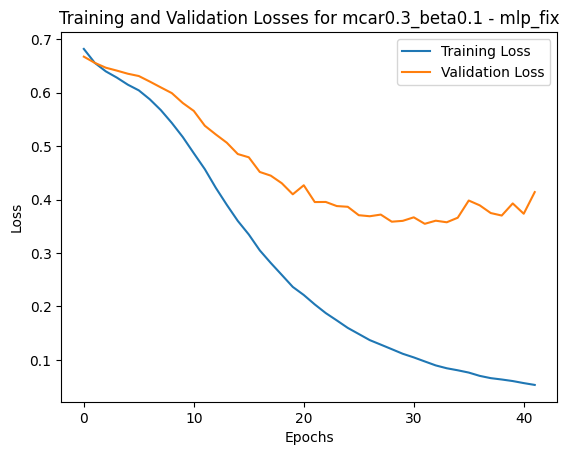

C:\Users\kr3164\AppData\Local\Temp\ipykernel_24292\776403985.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

Model loaded from outputs/baseline_mlp_fix_mcar0.3_beta0.1_lr0.01.pt


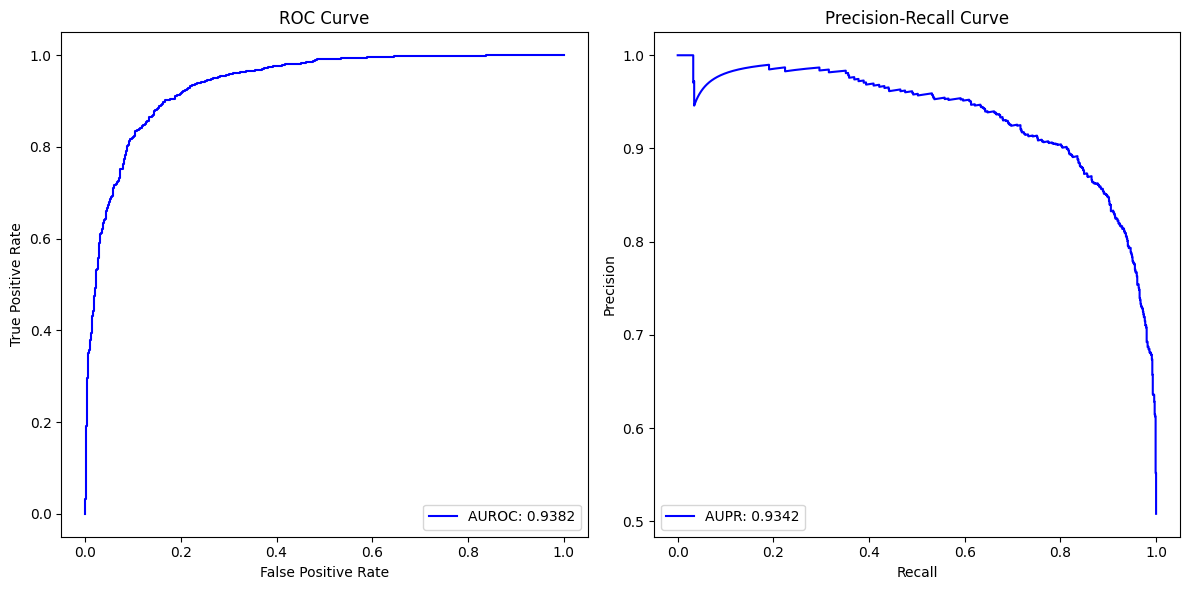

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.6876798275311788
Epoch [1/2000], Val Loss: 0.6817640690803528
Epoch [2/2000], Train Loss: 0.6769218614896139
Epoch [2/2000], Val Loss: 0.6791284384727478
Epoch [3/2000], Train Loss: 0.6713365929921468
Epoch [3/2000], Val Loss: 0.6777799663543701
Epoch [4/2000], Train Loss: 0.6650260372161865
Epoch [4/2000], Val Loss: 0.6758045711517334
Epoch [5/2000], Train Loss: 0.6575408701896668
Epoch [5/2000], Val Loss: 0.6746757965087891
Epoch [6/2000], Train Loss: 0.6483926813602447
Epoch [6/2000], Val Loss: 0.6770767526626587
Epoch [7/2000], Train Loss: 0.6355912791887919
Epoch [7/2000], Val Loss: 0.6750842843055725
Epoch [8/2000], Train Loss: 0.6212119550704956
Epoch [8/2000], Val Loss: 0.6697692136764526
Epoch [9/2000], Train Loss: 0.6028953427473704
Epoch [9/2000], Val Loss: 0.6697941927909851
Epoch [10/2000], Train Loss: 0.5808780337174734
Epoch [10/2000], Val Loss: 0.6747207548618317
Epoch [11/2000], Train Loss

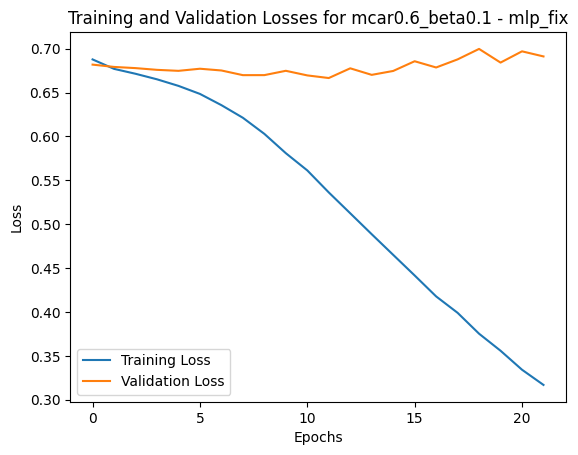

C:\Users\kr3164\AppData\Local\Temp\ipykernel_24292\776403985.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

Model loaded from outputs/baseline_mlp_fix_mcar0.6_beta0.1_lr0.01.pt


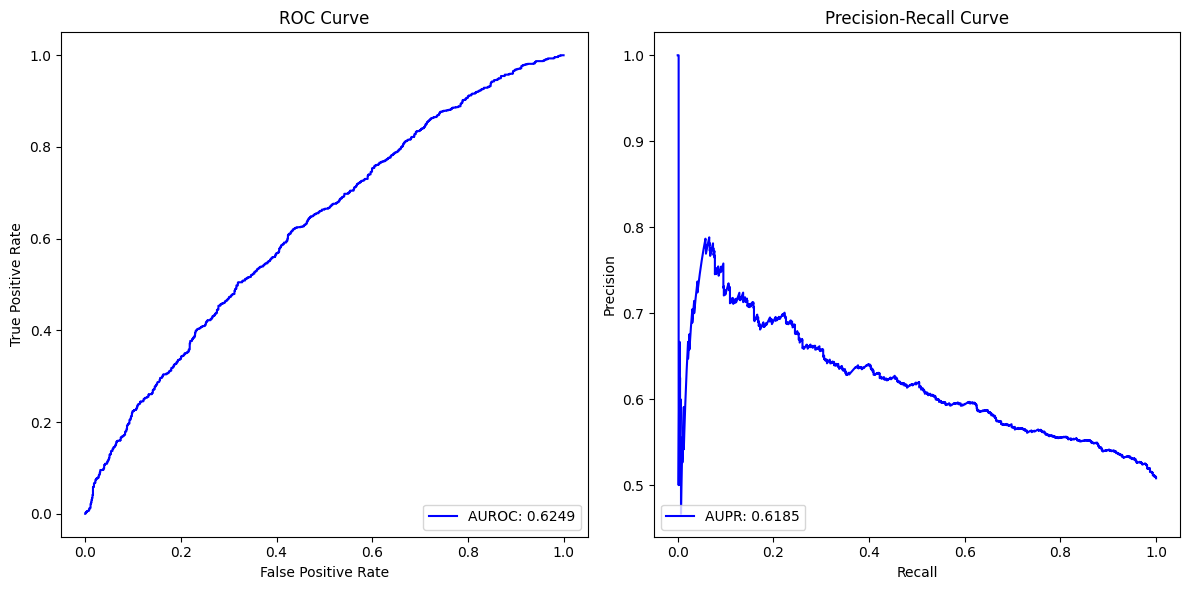

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.6793456026713054
Epoch [1/2000], Val Loss: 0.6654872450828552
Epoch [2/2000], Train Loss: 0.6560859028498331
Epoch [2/2000], Val Loss: 0.6547614271640778
Epoch [3/2000], Train Loss: 0.6395665365854899
Epoch [3/2000], Val Loss: 0.6462751944065094
Epoch [4/2000], Train Loss: 0.628944616317749
Epoch [4/2000], Val Loss: 0.6479703855514526
Epoch [5/2000], Train Loss: 0.6180712594985962
Epoch [5/2000], Val Loss: 0.6316306962966919
Epoch [6/2000], Train Loss: 0.6056085805098216
Epoch [6/2000], Val Loss: 0.6258137338161468
Epoch [7/2000], Train Loss: 0.5891682473023733
Epoch [7/2000], Val Loss: 0.6131331968307495
Epoch [8/2000], Train Loss: 0.5686070171197255
Epoch [8/2000], Val Loss: 0.6008200790882111
Epoch [9/2000], Train Loss: 0.5426139370600382
Epoch [9/2000], Val Loss: 0.5795227339267731
Epoch [10/2000], Train Loss: 0.5119287600517273
Epoch [10/2000], Val Loss: 0.562433746099472
Epoch [11/2000], Train Loss: 

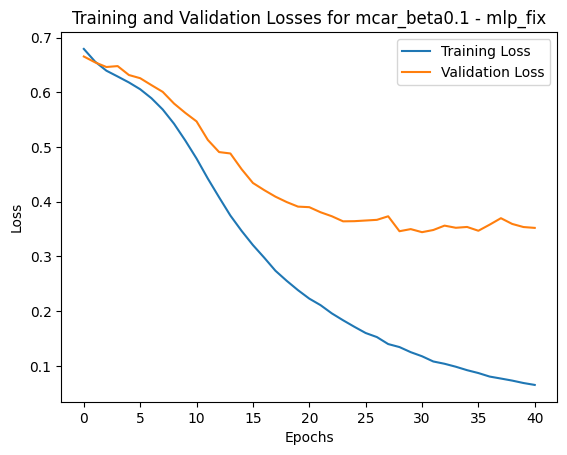

Model file not found: outputs/baseline_mlp_fix_mcar_beta0.1_lr0.01.pt


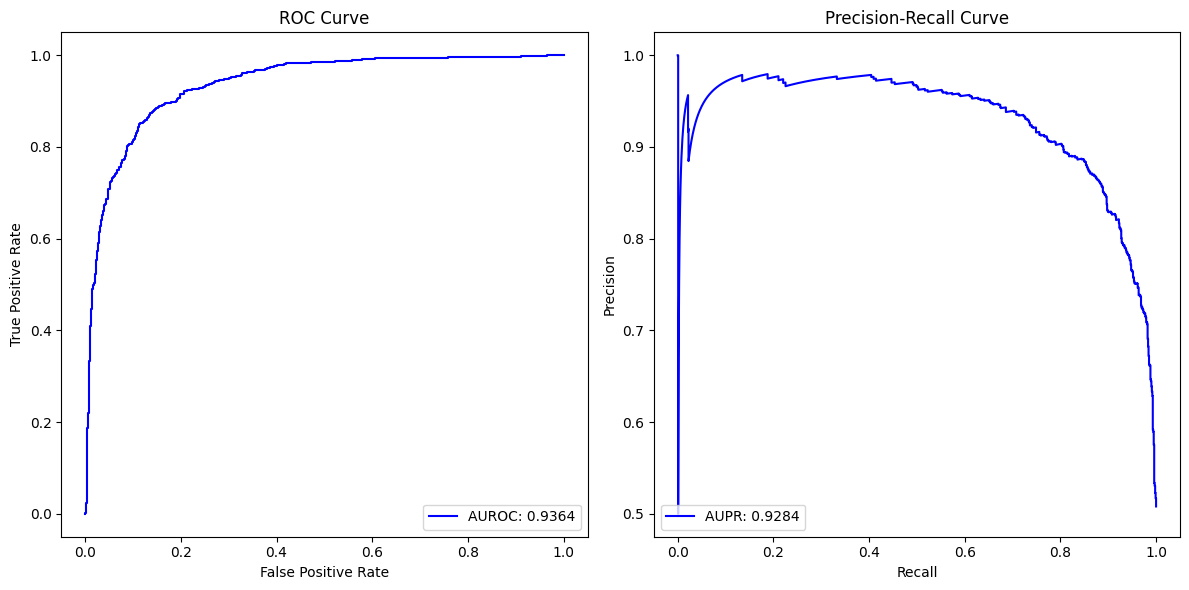

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.6936129741668701
Epoch [1/2000], Val Loss: 0.692335859298706
Epoch [2/2000], Train Loss: 0.6907816429138184
Epoch [2/2000], Val Loss: 0.6902000880241395
Epoch [3/2000], Train Loss: 0.6846006868680318
Epoch [3/2000], Val Loss: 0.6834872694015502
Epoch [4/2000], Train Loss: 0.6701654810905456
Epoch [4/2000], Val Loss: 0.6656101779937744
Epoch [5/2000], Train Loss: 0.6394433263142904
Epoch [5/2000], Val Loss: 0.6290501189231873
Epoch [6/2000], Train Loss: 0.5861341534455617
Epoch [6/2000], Val Loss: 0.5730613377094269
Epoch [7/2000], Train Loss: 0.5154967172145843
Epoch [7/2000], Val Loss: 0.5110075054168701
Epoch [8/2000], Train Loss: 0.45037559231122337
Epoch [8/2000], Val Loss: 0.4653918423652649
Epoch [9/2000], Train Loss: 0.399389746149381
Epoch [9/2000], Val Loss: 0.45179296731948854
Epoch [10/2000], Train Loss: 0.35982420249780017
Epoch [10/2000], Val Loss: 0.3956103253364563
Epoch [11/2000], Train Los

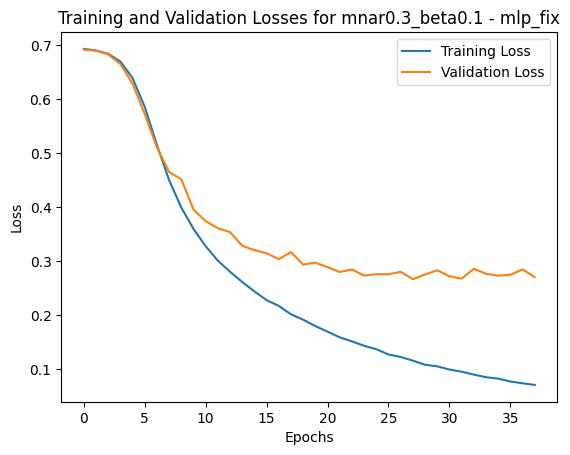

C:\Users\kr3164\AppData\Local\Temp\ipykernel_24292\776403985.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

Model loaded from outputs/baseline_mlp_fix_mnar0.3_beta0.1_lr0.01.pt


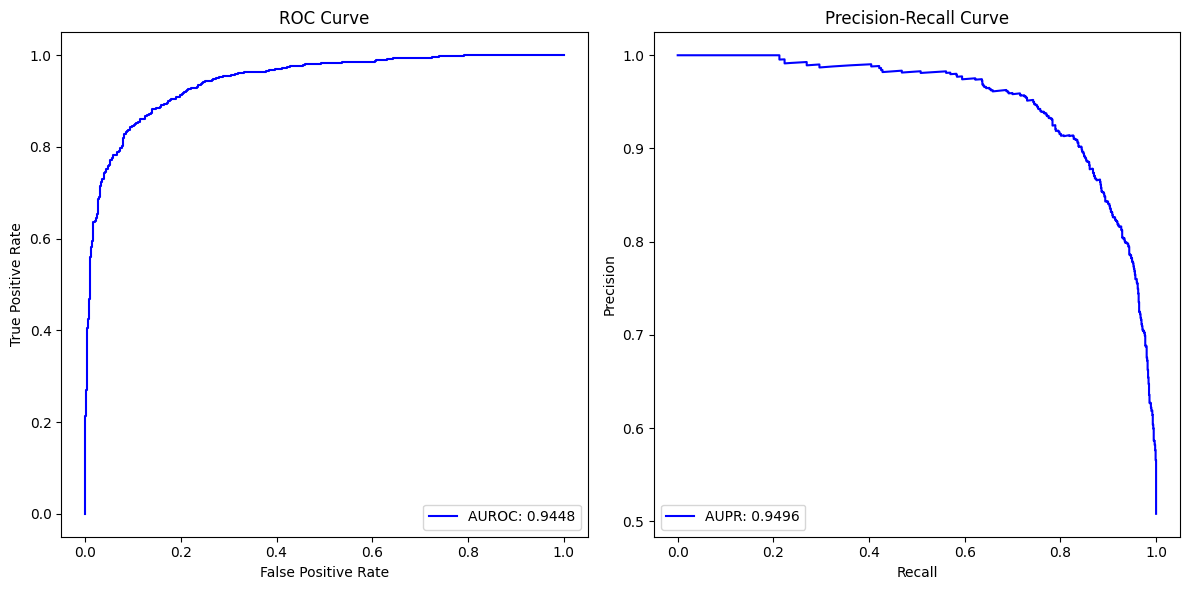

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.6717989242871603
Epoch [1/2000], Val Loss: 0.655720057964325
Epoch [2/2000], Train Loss: 0.6477955943743388
Epoch [2/2000], Val Loss: 0.6464929533004761
Epoch [3/2000], Train Loss: 0.6371499310334523
Epoch [3/2000], Val Loss: 0.6403787069320679
Epoch [4/2000], Train Loss: 0.6266313803990682
Epoch [4/2000], Val Loss: 0.6358243436813354
Epoch [5/2000], Train Loss: 0.6149423609574636
Epoch [5/2000], Val Loss: 0.6323452684879303
Epoch [6/2000], Train Loss: 0.6011598162651062
Epoch [6/2000], Val Loss: 0.6206601934432984
Epoch [7/2000], Train Loss: 0.5839830103715261
Epoch [7/2000], Val Loss: 0.6150185809135437
Epoch [8/2000], Train Loss: 0.5655646363099416
Epoch [8/2000], Val Loss: 0.6056681966781616
Epoch [9/2000], Train Loss: 0.5429572998682658
Epoch [9/2000], Val Loss: 0.6007068707942963
Epoch [10/2000], Train Loss: 0.5212301701704661
Epoch [10/2000], Val Loss: 0.5917868297100067
Epoch [11/2000], Train Loss:

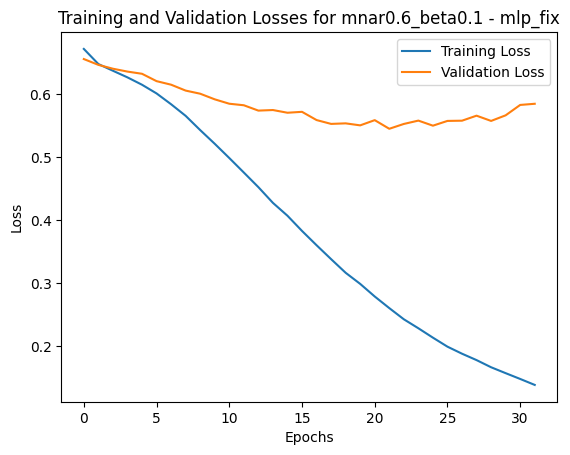

C:\Users\kr3164\AppData\Local\Temp\ipykernel_24292\776403985.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

Model loaded from outputs/baseline_mlp_fix_mnar0.6_beta0.1_lr0.01.pt


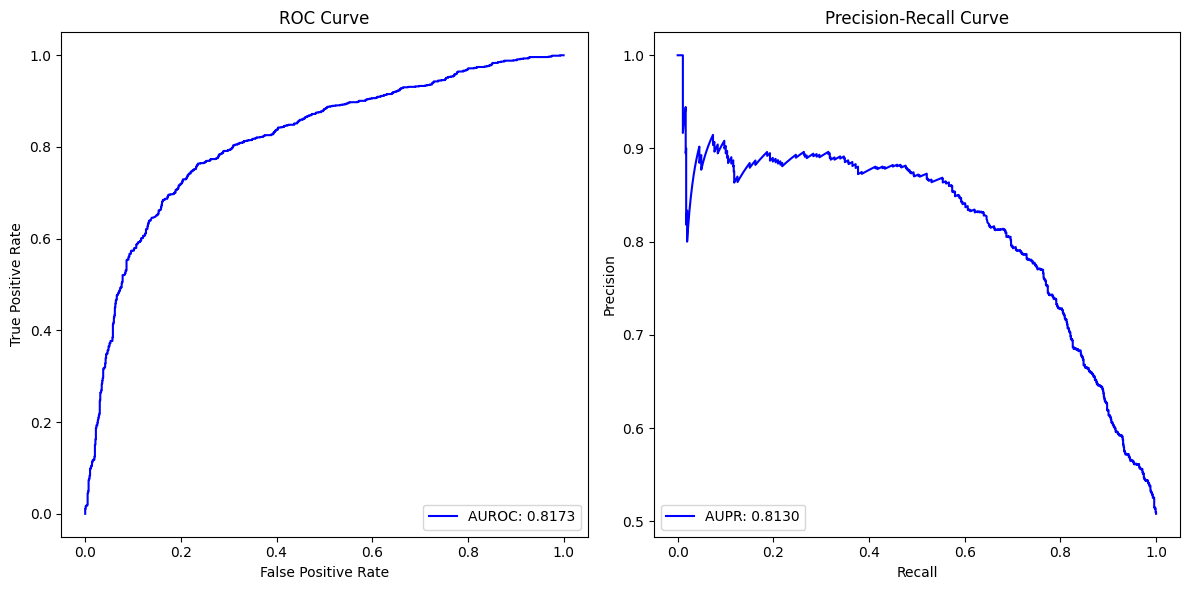

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.683177567799886
Epoch [1/2000], Val Loss: 0.6736196050643921
Epoch [2/2000], Train Loss: 0.666094964504242
Epoch [2/2000], Val Loss: 0.6658625454902649
Epoch [3/2000], Train Loss: 0.65372167746226
Epoch [3/2000], Val Loss: 0.6622263703346253
Epoch [4/2000], Train Loss: 0.6436812873681387
Epoch [4/2000], Val Loss: 0.6607503204345703
Epoch [5/2000], Train Loss: 0.633970173517863
Epoch [5/2000], Val Loss: 0.6557476830482483
Epoch [6/2000], Train Loss: 0.6189180470307668
Epoch [6/2000], Val Loss: 0.6514724869728088
Epoch [7/2000], Train Loss: 0.6056484741369883
Epoch [7/2000], Val Loss: 0.6571399512290954
Epoch [8/2000], Train Loss: 0.5847918386459351
Epoch [8/2000], Val Loss: 0.6392649168968201
Epoch [9/2000], Train Loss: 0.5609854302406311
Epoch [9/2000], Val Loss: 0.6371895091533661
Epoch [10/2000], Train Loss: 0.5360214613278707
Epoch [10/2000], Val Loss: 0.620387095451355
Epoch [11/2000], Train Loss: 0.50

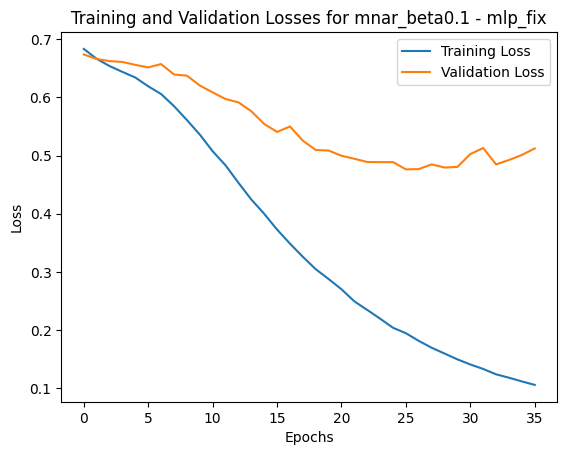

Model file not found: outputs/baseline_mlp_fix_mnar_beta0.1_lr0.01.pt


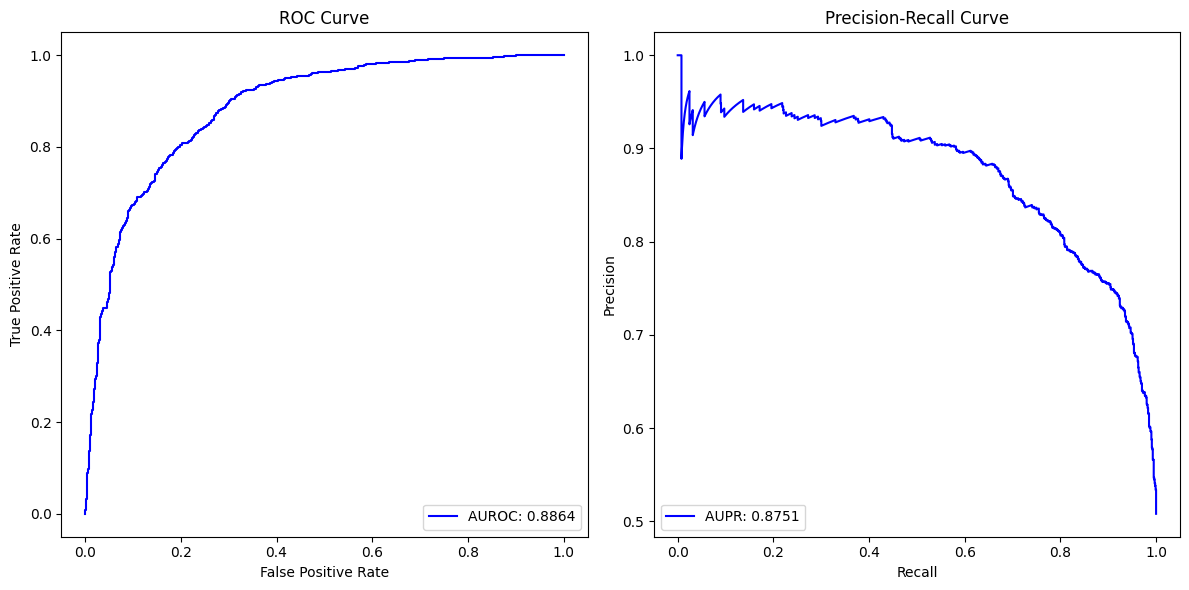

normalize data
create datasets
create trainloaders
Epoch [1/2000], Train Loss: 0.6285780150095622
Epoch [1/2000], Val Loss: 0.5266972439289093
Epoch [2/2000], Train Loss: 0.41276624039808907
Epoch [2/2000], Val Loss: 0.3152341618537903
Epoch [3/2000], Train Loss: 0.26082278215885163
Epoch [3/2000], Val Loss: 0.21266759365797042
Epoch [4/2000], Train Loss: 0.18495905389388403
Epoch [4/2000], Val Loss: 0.17880139684677124
Epoch [5/2000], Train Loss: 0.14456689876317977
Epoch [5/2000], Val Loss: 0.1532084773480892
Epoch [6/2000], Train Loss: 0.11997639812529087
Epoch [6/2000], Val Loss: 0.11269394673407078
Epoch [7/2000], Train Loss: 0.10349923726419608
Epoch [7/2000], Val Loss: 0.09667962044477463
Epoch [8/2000], Train Loss: 0.09046342377116283
Epoch [8/2000], Val Loss: 0.08934132370352744
Epoch [9/2000], Train Loss: 0.08225767880740265
Epoch [9/2000], Val Loss: 0.08641552722454071
Epoch [10/2000], Train Loss: 0.07732636426016688
Epoch [10/2000], Val Loss: 0.07928778801858426
Epoch [11/2

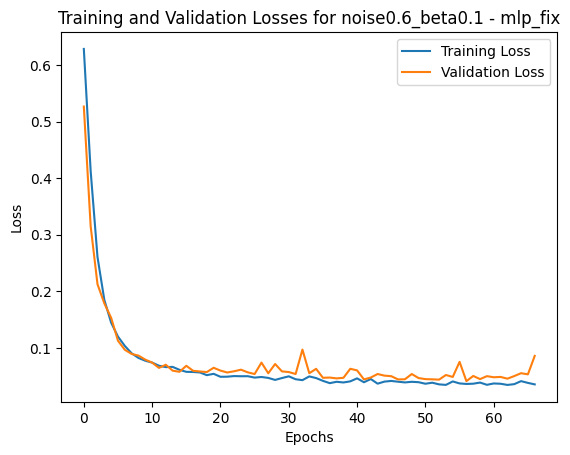

C:\Users\kr3164\AppData\Local\Temp\ipykernel_24292\776403985.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

Model loaded from outputs/baseline_mlp_fix_noise0.6_beta0.1_lr0.01.pt


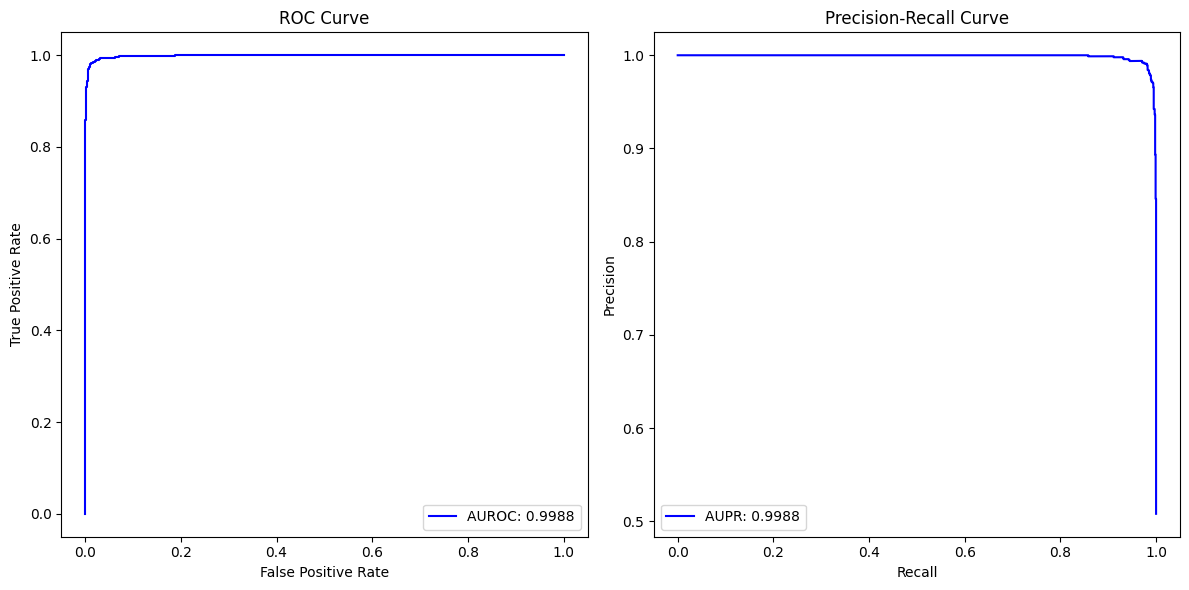

In [36]:
import os
import pickle
import torch
from training import Training  # Ensure the correct import path for your Training class
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import numpy as np

# Set the device for PyTorch (use 'cuda' for GPU if available)
device = torch.device('cpu')  # Change to 'cuda' if using GPU

# Define lists for model configurations you want to try
model_names = ['mlp_fix']  # List of model names/configurations
annotations = ['_lr0.01']  # List of annotations to distinguish model variants

# Define model parameters (modify as per your requirements)
input_dim = 49
hidden_dim = 1536

# Loop through each model configuration and dataset
for model_name in model_names:
    for add_annot in annotations:
        for filename in os.listdir('datasets'):
            if filename.endswith('.pickle'):
                # Extract the dataset name without the file extension
                name = filename.replace('.pickle', '')

                # Load the dataset
                with open(f'datasets/{name}.pickle', 'rb') as handle:
                    trends_data = pickle.load(handle)

                # Initialize the Training class with specified parameters
                training = Training(
                    trends_data,
                    model=model_name,
                    input_dim=input_dim,
                    hidden_dim=hidden_dim,
                    device=device
                )

                # Run the training process
                best_model, train_loss, val_loss = training.training()

                # Define paths for saving model and loss data
                model_save_path = f'outputs/baseline_{model_name}_{name}{add_annot}.pt'
                train_loss_save_path = f'outputs/train_losses_{model_name}_{name}{add_annot}.pickle'
                val_loss_save_path = f'outputs/val_losses_{model_name}_{name}{add_annot}.pickle'

                # Save the trained model
                try:
                    torch.save(best_model.state_dict(), model_save_path)
                    print(f"Model saved as {model_save_path}")
                except Exception as e:
                    print(f"Error saving model: {e}")

                # Save training and validation losses
                with open(train_loss_save_path, 'wb') as handle:
                    pickle.dump(train_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
                print(f"Training losses saved as {train_loss_save_path}")

                with open(val_loss_save_path, 'wb') as handle:
                    pickle.dump(val_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
                print(f"Validation losses saved as {val_loss_save_path}")

                # Plot training and validation losses
                plt.plot(train_loss, label='Training Loss')
                plt.plot(val_loss, label='Validation Loss')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.legend(['Training Loss', 'Validation Loss'])
                plt.title(f'Training and Validation Losses for {name} - {model_name}')
                plt.show()

                # Initialize the test loader and load the trained model
                test_loader = training.data_splits.test_loader
                model = training.model

                # Load the trained model state if it exists
                if os.path.exists(model_save_path):
                    try:
                        model.load_state_dict(torch.load(model_save_path, map_location=device))
                        print(f"Model loaded from {model_save_path}")
                    except Exception as e:
                        print(f"Error loading model: {e}")
                else:
                    print(f"Model file not found: {model_save_path}")

                # Function to create a padding mask
                def create_padding_mask(seq_lengths, max_len):
                    batch_size = len(seq_lengths)
                    mask = torch.zeros(batch_size, max_len, dtype=torch.bool)
                    for i, seq_len in enumerate(seq_lengths):
                        mask[i, seq_len:] = True
                    return mask

                # Evaluate the model
                model.eval()
                all_outputs, all_labels = [], []
                with torch.no_grad():
                    for sequences, labels in test_loader:
                        sequences, labels = sequences.to(device), labels.float().to(device)
                        seq_lengths = [len(seq[seq != 0]) for seq in sequences]
                        max_len = sequences.size(1)
                        mask = create_padding_mask(seq_lengths, max_len).to(device)
                        outputs = model(sequences, mask)
                        all_outputs.extend(outputs.detach().cpu().numpy())
                        all_labels.extend(labels.detach().cpu().numpy())

                # Plot ROC and PR curves
                def roc_pr(outputs, labels, plot='no'):
                    fpr, tpr, _ = roc_curve(np.array(labels), np.array(outputs))
                    pre, rec, _ = precision_recall_curve(np.array(labels), np.array(outputs))

                    if plot == 'yes':
                        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
                        roc_auc = auc(fpr, tpr)
                        ax1.plot(fpr, tpr, color='b', label=f'AUROC: {roc_auc:.4f}')
                        pr_auc = auc(rec, pre)
                        ax2.plot(rec, pre, color='b', label=f'AUPR: {pr_auc:.4f}')
                        ax1.set_title('ROC Curve')
                        ax1.set_xlabel('False Positive Rate')
                        ax1.set_ylabel('True Positive Rate')
                        ax1.legend(loc="lower right")
                        ax2.set_title('Precision-Recall Curve')
                        ax2.set_xlabel('Recall')
                        ax2.set_ylabel('Precision')
                        ax2.legend(loc="lower left")
                        plt.tight_layout()
                        plt.show()

                # Plot ROC and PR curves
                roc_pr(all_outputs, all_labels, plot='yes')
